In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 

In [2]:
data = pd.read_csv("/home/ivana/Desktop/IP-projekat/2023_Data_Mining_Smoking_Dataset/datasets/data1.csv")
data.columns

Index(['Unnamed: 0', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'tartar',
       'smoking'],
      dtype='object')

In [3]:
data.drop('Unnamed: 0', axis=1,inplace=True)

In [4]:
data.shape

(55692, 25)

In [5]:
Y = data['smoking']
X = data.drop('smoking', axis=1)
feature_names = X.columns
X.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0
3,1,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,1
4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0


Meni vise smetaju ekstremni autlajeri na +-3IQR. Vidimo da atribut dental caries ima 21% autlajera. U ostalim atributima procenat autlajera je jako mali ili ih uopste nema.

In [6]:
def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (3 * IQR)
        lower = Q1 - (3 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify=Y, random_state=12)

Nakon podele na test i trening skup radimo detekciju elemenata van granica inace bismo kompromitovali test skup.

In [13]:
iqr= IQR(X_train, feature_names)
print(iqr)

                     lower    min  num_lower  upper     max  num_upper  \
gender                -3.0    0.0          0    4.0     1.0          0   
age                   -5.0   20.0          0  100.0    85.0          0   
height(cm)           130.0  130.0          0  200.0   190.0          0   
weight(kg)            -5.0   30.0          0  135.0   135.0          0   
waist(cm)             40.0   51.0          0  124.0   129.0          8   
eyesight(left)        -0.4    0.1          0    2.4     9.9         92   
eyesight(right)       -0.4    0.1          0    2.4     9.9         92   
hearing(left)          1.0    1.0          0    1.0     2.0       1425   
hearing(right)         1.0    1.0          0    1.0     2.0       1456   
systolic              58.0   71.0          0  184.0   240.0         49   
relaxation            34.0   40.0          0  118.0   146.0         55   
fasting blood sugar   44.0   46.0          0  149.0   505.0       1410   
Cholesterol           28.0   55.0     

In [14]:
import numpy as np

def replace_outliers_with_median(data):
    sorted_data = np.sort(data)
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    iqr = q3 - q1

    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr

    median = np.median(data)

    replaced_data = np.where(
        (data < lower_bound) | (data > upper_bound),
        median,
        data
    )

    return replaced_data


In [15]:
column_num = len(feature_names)
for i in range(0,column_num):
    column_name = feature_names[i];
    p = iqr.iat[i,6];
    if p >= 1:
        data[column_name] = replace_outliers_with_median(data[column_name])

In [16]:
IQR(X_train, feature_names)

,lower,min,num_lower,upper,max,num_upper,percantage
gender,-3.0,0.0,0,4.0,1.0,0,0
age,-5.0,20.0,0,100.0,85.0,0,0
height(cm),130.0,130.0,0,200.0,190.0,0,0
weight(kg),-5.0,30.0,0,135.0,135.0,0,0
waist(cm),40.0,51.0,0,124.0,129.0,8,0
eyesight(left),-0.4,0.1,0,2.4,9.9,92,0
eyesight(right),-0.4,0.1,0,2.4,9.9,92,0
hearing(left),1.0,1.0,0,1.0,2.0,1425,3
hearing(right),1.0,1.0,0,1.0,2.0,1456,3
systolic,58.0,71.0,0,184.0,240.0,49,0


Mozemo zakljuciti da nam menjanje autlajera medijanom nije pomoglo. :)

Normalizacija:

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit_transform(X_train)


array([[ 0.06123489, -0.71402853, -0.05347329, -0.13188512,  0.07796089,
         0.03819073],
       [ 0.04894811, -0.72601615, -0.05794323, -0.09326495, -0.01246074,
         0.13434399],
       [-0.47623149,  0.05449262, -0.38971533, -0.04631708,  0.07474861,
        -0.13252191],
       ...,
       [ 0.86695188, -0.03875523,  0.06192799, -0.12151736, -0.00667022,
         0.15965882],
       [-0.516993  ,  0.03300804, -0.38672836, -0.1677387 ,  0.14402471,
         0.06022648],
       [-0.49750933,  0.0338846 , -0.39447794,  0.02908575, -0.07263167,
         0.00331122]])

In [41]:
pca.components_.shape

(6, 24)

In [42]:
pca_names = [f'Principal_component_{i}' for i in range(pca.n_components_)]

In [43]:
for i, component in enumerate(pca.components_):
    print(f'{pca_names[i]} = ', end='')
    print(' + '.join(f'{coef:.2f}*{feature_name}'
                     for coef, feature_name in zip(component, feature_names)))
    print('-'*80)


Principal_component_0 = -0.70*gender + 0.12*age + -0.20*height(cm) + -0.12*weight(kg) + -0.08*waist(cm) + -0.01*eyesight(left) + -0.01*eyesight(right) + 0.01*hearing(left) + 0.01*hearing(right) + -0.02*systolic + -0.03*relaxation + -0.01*fasting blood sugar + 0.01*Cholesterol + -0.06*triglyceride + 0.01*HDL + 0.00*LDL + -0.11*hemoglobin + -0.00*Urine protein + -0.01*serum creatinine + -0.00*AST + -0.00*ALT + -0.02*Gtp + -0.29*dental caries + -0.58*tartar
--------------------------------------------------------------------------------
Principal_component_1 = -0.60*gender + 0.05*age + -0.16*height(cm) + -0.09*weight(kg) + -0.07*waist(cm) + -0.01*eyesight(left) + -0.01*eyesight(right) + -0.01*hearing(left) + -0.00*hearing(right) + -0.02*systolic + -0.02*relaxation + -0.01*fasting blood sugar + 0.01*Cholesterol + -0.04*triglyceride + 0.01*HDL + 0.00*LDL + -0.09*hemoglobin + -0.00*Urine protein + -0.01*serum creatinine + -0.00*AST + -0.00*ALT + -0.01*Gtp + 0.19*dental caries + 0.75*tartar
-

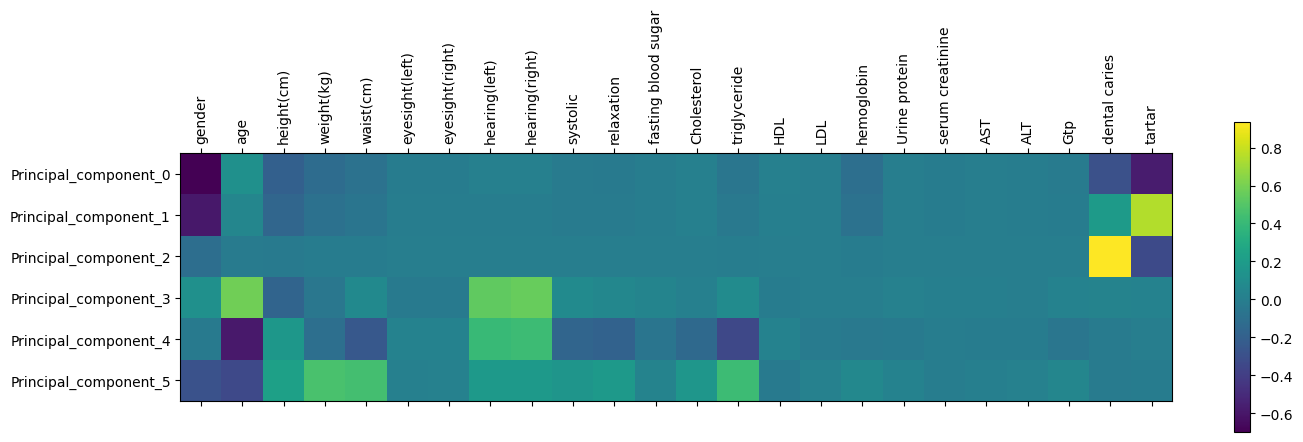

In [44]:
from matplotlib import pyplot as plt

plt.matshow(pca.components_)
plt.xticks(ticks=range(pca.components_.shape[1]),
           labels=feature_names,
           rotation='vertical')
plt.yticks(ticks=range(pca.n_components_),
           labels=pca_names)
plt.colorbar()
plt.show()

In [45]:
pca.explained_variance_

array([0.28656239, 0.24282757, 0.15350848, 0.04553631, 0.02837003,
       0.02480001])

In [46]:
pca.explained_variance_ratio_

array([0.33356355, 0.28265548, 0.17868651, 0.05300505, 0.0330232 ,
       0.02886764])

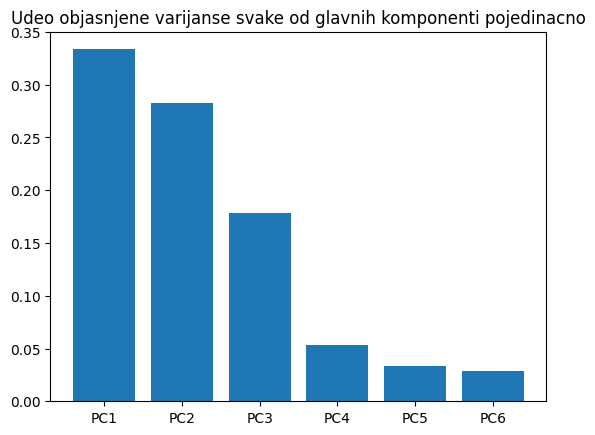

In [48]:
plt.bar(x=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'],
        height=pca.explained_variance_ratio_)
plt.title('Udeo objasnjene varijanse svake od glavnih komponenti pojedinacno')
plt.show()

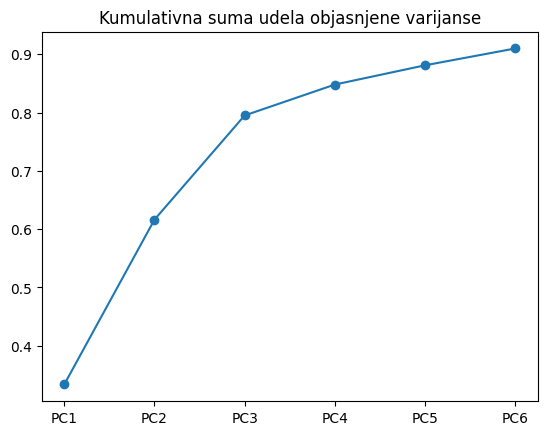

In [50]:
import numpy as np

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], cumulative_variance_ratio, marker='o')
plt.title('Kumulativna suma udela objasnjene varijanse')
plt.show()

Mozemo primetiti da prve tri glavne komponente objasnjavaju ukupno vise od 90% ukupne varijanse podataka.

In [51]:
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Izvestaj o klasifikaciji za model{} nad {} podacima".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Matrica konfuzije za model {} nad {} podacima ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['1', '0'], index=['1', '0']))
    print("---------------------------------------------------------------------------------")
    


Treniramo model:

In [52]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train) # treninranje modela

KNeighborsClassifier()

In [53]:
report(knn, X_train, Y_train)

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad training podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     23608
           1       0.76      0.75      0.76     13705

    accuracy                           0.82     37313
   macro avg       0.81      0.81      0.81     37313
weighted avg       0.82      0.82      0.82     37313

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad training podacima 
---------------------------------------------------------------------------------
       1      0
1  20343   3265
0   3388  10317
---------------------------------------------------------------------------------


Vidimo da je f1-score nad trening skupom 0.86, dok je  nad test skupom 0.79.

In [54]:
report(knn, X_test, Y_test, "test")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad test podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     11629
           1       0.64      0.63      0.63      6750

    accuracy                           0.73     18379
   macro avg       0.71      0.71      0.71     18379
weighted avg       0.73      0.73      0.73     18379

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad test podacima 
---------------------------------------------------------------------------------
      1     0
1  9225  2404
0  2505  4245
---------------------------------------------------------------------------------


Unapredjenje podesavanjem hiperparametara. Proveravamo koja kombinacija hiper-parametara ce dati najbolji model:

In [55]:
import math
math.ceil(math.sqrt(X_train.shape[0]))

194

In [56]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'n_neighbors':[70,160,180], 
    'weights': ['uniform', 'distance'],
    'metric':['minkowski','manhattan','l1','l2']
}

# Tune the model.
tuning_knn = GridSearchCV(knn, param_grid, verbose = 1, cv=10, 
                          scoring='accuracy', n_jobs = -1, return_train_score=True)
tuning_knn.fit(X_train, Y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'manhattan', 'l1', 'l2'],
                         'n_neighbors': [70, 160, 180],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [57]:
tuning_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 160, 'weights': 'distance'}

In [58]:
tuning_knn.best_score_

0.8030979686143986

In [59]:
report(tuning_knn.best_estimator_, X_train, Y_train)

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad training podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23608
           1       1.00      1.00      1.00     13705

    accuracy                           1.00     37313
   macro avg       1.00      1.00      1.00     37313
weighted avg       1.00      1.00      1.00     37313

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad training podacima 
---------------------------------------------------------------------------------
       1      0
1  23608      0
0      0  13705
---------------------------------------------------------------------------------


PREPRILAGODIO SE???!!!!???

In [60]:
report(tuning_knn.best_estimator_, X_test, Y_test, "test")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad test podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     11629
           1       0.73      0.78      0.75      6750

    accuracy                           0.81     18379
   macro avg       0.80      0.80      0.80     18379
weighted avg       0.81      0.81      0.81     18379

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad test podacima 
---------------------------------------------------------------------------------
      1     0
1  9666  1963
0  1510  5240
---------------------------------------------------------------------------------


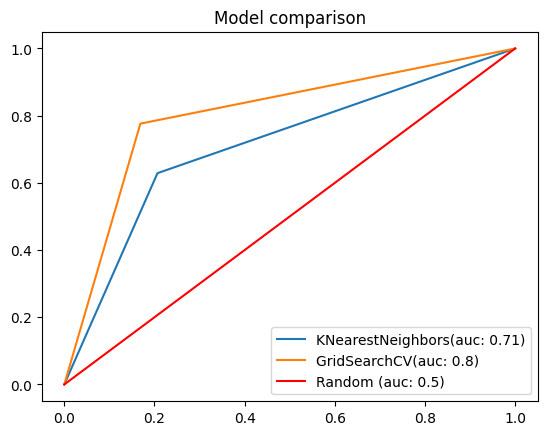

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [knn, tuning_knn.best_estimator_]
model_names = ['KNearestNeighbors', 'GridSearchCV']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()
